#**Procedimiento para análisis de plagas**


##**Definición del problema**

**Objetivo:** Predecir el nivel de riesgo de plaga para el próximo mes utilizando datos de los 6 meses previos. En esta etapa se define claramente el problema y qué datos se requieren. Por ejemplo, podría tratarse de predecir el número de insectos/plagas esperados en un cultivo el mes siguiente, basándose en factores históricos como clima, humedad, tratamientos, etc. Es importante identificar qué variables influyen en el riesgo de plaga (temperatura, precipitación, humedad, tipo de cultivo, incidencias de plaga observadas, etc.) y cómo obtener esos datos. También es posible predecir datos de producción basados en la información previa.

###**Carga de datos y construcción del DataFrame**

In [49]:
# Importación de librerias
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_poisson_deviance

from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns

# Gráficas dinámicas
import plotly.graph_objects as go
import plotly.express as px


In [4]:
# Cargar datos de github
RAW_URL = "https://raw.githubusercontent.com/Da-Pe-Al/Analisis-de-plagas/main/plagas_sintetico_5000.csv"

# Leer csv
df = pd.read_csv(RAW_URL, encoding="utf-8-sig")

# Normalizar nombres de las columnas
df = df.rename(columns={
    "TemperaturaPromedio (°C)": "Temperatura",
    "Precipitación (mm)": "Precipitación",
    "IncidenciaPlaga": "Plaga",
})

# Asegurar la columna 'Mes' como datetime mensual (si viene tipo 'YYYY-MM')
df["Mes"] = pd.to_datetime(df["Mes"],format="%Y-%m", errors="coerce").dt.to_period("M").dt.to_timestamp("s")


# Tipos numéricos seguros
df["Temp"]  = pd.to_numeric(df["Temperatura"], errors="coerce")
df["Prec"]  = pd.to_numeric(df["Precipitación"], errors="coerce")
df["plaga"] = pd.to_numeric(df["Plaga"], errors="coerce").astype("Int64")  # usa int64 si no hay NA

# Orden temporal
df = df.sort_values("Mes").reset_index(drop=True)



print(df.head())
print(df.dtypes)
print(df.describe())


         Mes  Temperatura  Precipitación  Plaga   Temp  Prec  plaga
0 2019-01-01        18.53            0.0      0  18.53   0.0      0
1 2019-01-01        16.32           30.2      1  16.32  30.2      1
2 2019-01-01        18.62           49.2      1  18.62  49.2      1
3 2019-01-01        20.07           17.3      2  20.07  17.3      2
4 2019-01-01        19.61           24.0      3  19.61  24.0      3
Mes              datetime64[ns]
Temperatura             float64
Precipitación           float64
Plaga                     int64
Temp                    float64
Prec                    float64
plaga                     Int64
dtype: object
                                 Mes  Temperatura  Precipitación        Plaga  \
count                           5000  5000.000000    5000.000000  5000.000000   
mean   2022-06-12 22:26:58.560000256    22.942204      81.049120     4.924200   
min              2019-01-01 00:00:00    11.760000       0.000000     0.000000   
25%              2020-09-01 00

### **Preprocesamiento y Normalización**

In [ ]:
# Extrae mes (1..12) desde MesLabel
def extract_month_col(X: pd.DataFrame) -> pd.DataFrame:
    m = pd.to_datetime(X['Mes']).dt.month.to_frame(name='month')
    return m

month_extractor = FunctionTransformer(extract_month_col, validate=False)

# Aplica log1p SOLO a Prec; Temp pasa tal cual; luego escalar ambas
log_prec = ColumnTransformer(
    transformers=[
        ('prec_log', FunctionTransformer(np.log1p, validate=False), ['Precipitación']),
        ('temp_passthrough', 'passthrough', ['Temperatura'])
    ],
    remainder='drop'
)

num_scaled = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_prec', log_prec),
    ('scale', StandardScaler())
])

time_pipe = Pipeline(steps=[
    ('month', month_extractor),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', num_scaled, ['Temperatura','Precipitación']),
        ('time', time_pipe, ['Mes']),
    ],
    remainder='drop'
)


        .reset_index())

###**Análisis exploratorio de los Datos**

       Temperatura        Plaga  Precipitación
count  5000.000000  5000.000000    5000.000000
mean     22.942204     4.924200      81.049120
std       3.947848     3.938319      59.856111
min      11.760000     0.000000       0.000000
25%      19.700000     2.000000      32.775000
50%      23.145000     4.000000      59.500000
75%      26.112500     8.000000     140.000000
max      34.870000    23.000000     239.400000


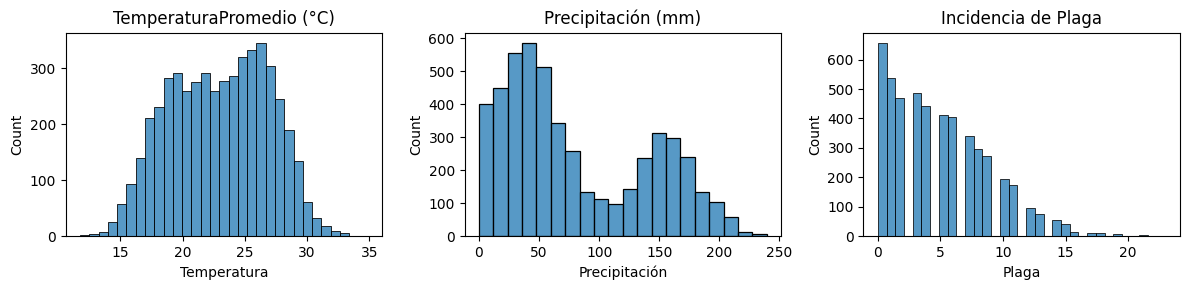

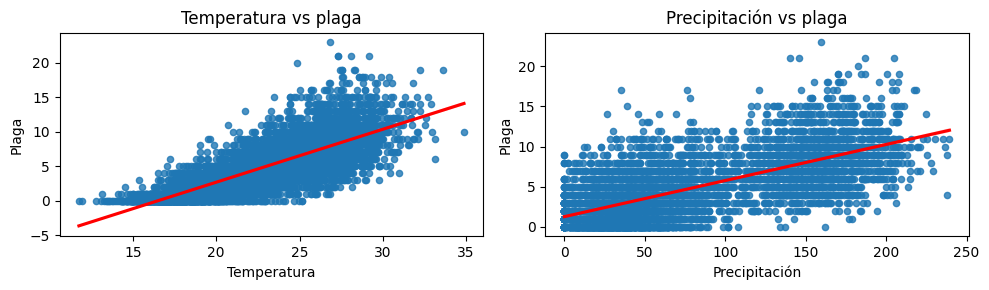

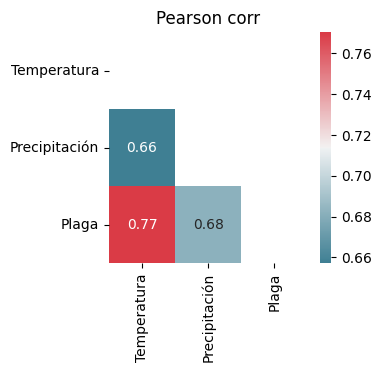

In [43]:
# EDA Sin Resample Mensual
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Definir la relación nula=0 como color blanco

mascara = np.zeros_like(corr, dtype=bool) #Eliminar la parte superior del cuadrado del Heat map
mascara[np.triu_indices_from(mascara)] = True

print(df[['Temperatura', 'Plaga', 'Precipitación']].describe())

# Distribuciones
fig, axes = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(df['Temperatura'], ax=axes[0]); axes[0].set_title('TemperaturaPromedio (°C)')
sns.histplot(df['Precipitación'], ax=axes[1]); axes[1].set_title('Precipitación (mm)')
sns.histplot(df['Plaga'], ax=axes[2]); axes[2].set_title('Incidencia de Plaga')
plt.tight_layout(); plt.show()

# Dispersión
fig, axes = plt.subplots(1, 2, figsize=(10,3))
sns.regplot(x='Temperatura', y='Plaga', data=df, ax=axes[0], line_kws={'color':'red'},scatter_kws={"s": 20}); axes[0].set_title('Temperatura vs plaga')
sns.regplot(x='Precipitación', y='Plaga', data=df, ax=axes[1], line_kws={'color':'red'},scatter_kws={"s": 20}); axes[1].set_title('Precipitación vs plaga')
plt.tight_layout(); plt.show()

# Correlación (Pearson)
corr = df[['Temperatura','Precipitación','Plaga']].corr(method='pearson')
plt.figure(figsize=(3.2,3))
sns.heatmap(corr, mask=mascara, annot=True, fmt='.2f', cmap=cmap)
plt.title('Pearson corr'); plt.show()


       Temperatura      Plaga  Precipitación
count    84.000000  84.000000      84.000000
mean     22.985722   4.972127    4824.352381
std       3.425719   2.989443    3435.721299
min      17.649643   0.821429    1048.600000
25%      19.647083   2.233333    2105.275000
50%      23.469842   4.797523    3131.400000
75%      26.326866   8.208333    8136.350000
max      27.723226  10.465517   13429.900000


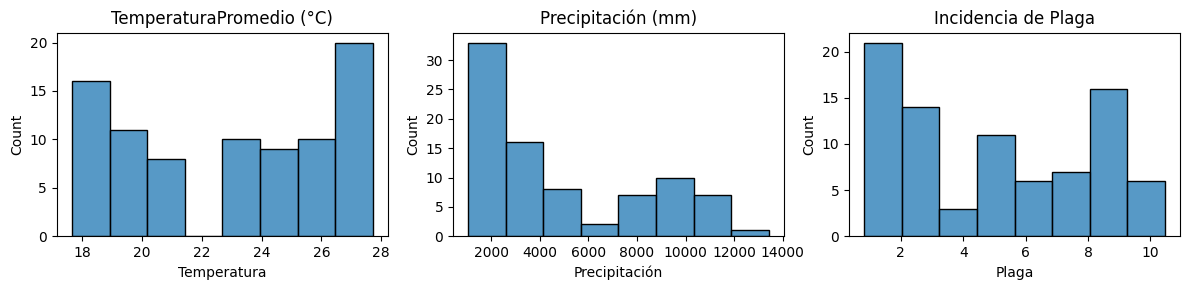

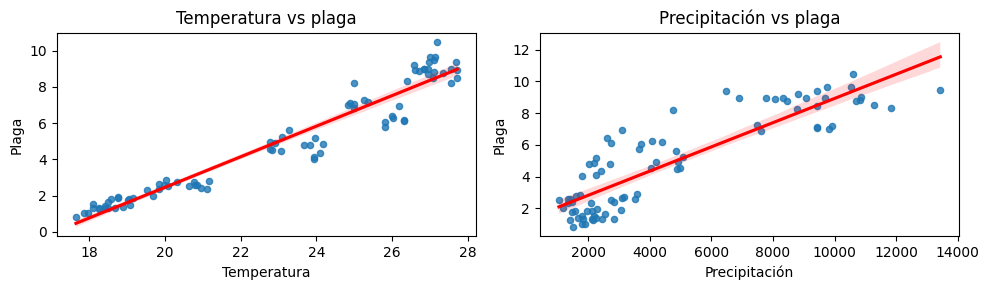

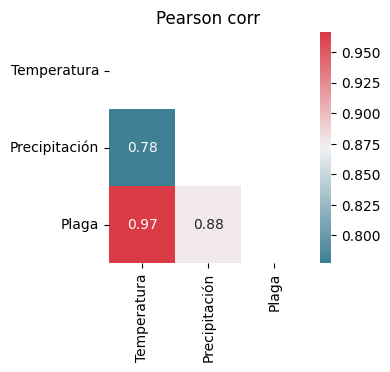

In [44]:
# Resample mensual
df2 = (df.set_index("Mes")
        .resample("MS")
        .agg({
            "Temperatura": "mean",
            "Precipitación": "sum",
            "Plaga": "mean"
        })
        .reset_index()
)
# EDA Con Resample Mensual
print(df2[['Temperatura', 'Plaga', 'Precipitación']].describe())

# Distribuciones
fig, axes = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(df2['Temperatura'], ax=axes[0]); axes[0].set_title('TemperaturaPromedio (°C)')
sns.histplot(df2['Precipitación'], ax=axes[1]); axes[1].set_title('Precipitación (mm)')
sns.histplot(df2['Plaga'], ax=axes[2]); axes[2].set_title('Incidencia de Plaga')
plt.tight_layout(); plt.show()

# Dispersión
fig, axes = plt.subplots(1, 2, figsize=(10,3))
sns.regplot(x='Temperatura', y='Plaga', data=df2, ax=axes[0], line_kws={'color':'red'},scatter_kws={"s": 20}); axes[0].set_title('Temperatura vs plaga')
sns.regplot(x='Precipitación', y='Plaga', data=df2, ax=axes[1], line_kws={'color':'red'},scatter_kws={"s": 20}); axes[1].set_title('Precipitación vs plaga')
plt.tight_layout(); plt.show()

# Correlación (Pearson)
corr = df2[['Temperatura','Precipitación','Plaga']].corr(method='pearson')
plt.figure(figsize=(3.2,3))
sns.heatmap(corr, mask=mascara, annot=True, fmt='.2f', cmap=cmap)
plt.title('Pearson corr'); plt.show()

# Figura base
fig = go.Figure()

# Barras: Temperatura (y)
fig.add_trace(go.Bar(
    name="TemperaturaPromedio (°C)",
    x=df2["Mes"],
    y=df2["Temperatura"],
    hovertemplate="Mes=%{x}<br>Temp=%{y:.2f} °C<extra></extra>"
))

# Barras: Precipitación (y2)
fig.add_trace(go.Bar(
    name="Precipitación (mm)",
    x=df2["Mes"],
    y=df2["Precipitación"],
    yaxis="y2",
    hovertemplate="Mes=%{x}<br>Temp=%{y:.2f} °C<extra></extra>"
))

# Dispersión: Incidencia de plaga (y3)
fig.add_trace(go.Scatter(
    name="Incidencia de plaga",
    x=df2["Mes"],
    y=df2["Plaga"],
    mode="lines+markers",
    yaxis="y3",
    hovertemplate="Mes=%{x}<br>Temp=%{y:.2f} °C<extra></extra>"
))

# --- Layout con 3 ejes Y ---
fig.update_layout(
    title="Clima vs Incidencia de Plaga",
    barmode="group",  # Se puede elegir tipo como "overlay" o "stack"
    hovermode="x unified",
    legend=dict(orientation="h", y=1.1),
    # 1) Deja margen derecho reduciendo el dominio del eje X
    xaxis=dict(
        title="Fecha",
        type="date",
        domain=[0.0, 0.82],        # ← el área de dibujo termina en 0.82
        rangeslider=dict(visible=True)
    ),

    # y (izquierda) - Temperatura
    yaxis=dict(title="Temperatura (°C)", showgrid=True),

    # y2 (derecha, al borde del dominio x=0.82) - Precipitación
    yaxis2=dict(
        title="Precipitación (mm)",
        overlaying="y",
        side="right",
        position=0.82              # ← coincide con el fin del dominio del xaxis
    ),

    # y3 (más a la derecha, en el margen) - Incidencia
    yaxis3=dict(
        title="Incidencia de plaga",
        overlaying="y",
        side="right",
        anchor="free",             # ← habilita colocar el eje fuera del dominio del xaxis
        position=0.92,             # ← dentro de [0,1], pero a la derecha del 0.82
        showgrid=False
    ),

    margin=dict(r=110)             # deja espacio visual para el tercer eje
)

fig.show()

##**Regresión lineal**

In [71]:
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols

#Separación de los datos de prueba y de entrenamiento de la muestra sin resampleo mensual
y = df['Plaga']
X= df.drop(columns='Plaga')

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=230) #Garantizar la reproductividad de la segragacion de los datos

#Datos de entrenamiento para usar la fórmula
df_train =pd.DataFrame(X_train)
df_train['Plaga']=y_train

#Adición de factores al modelo
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
#Creando el modelo con todas las variables
modelo_Temp = sm.OLS(y_train,X_train[['Temperatura']]).fit()
modelo_Prec = sm.OLS(y_train,X_train[['Precipitación']]).fit()
modelo_mixto = sm.OLS(y_train,X_train[['Temperatura','Precipitación']]).fit()
#Resumen de los modelos
modelossm=[modelo_Temp,modelo_Prec,modelo_mixto]
for i,j in enumerate(modelos):
  print(f'****************************************************************************************** El modelo {i} tiene el siguiente resumen ************************************************************************')
  print(j.summary(), '\n\n')

****************************************************************************************** El modelo 0 tiene el siguiente resumen ************************************************************************
                            OLS Regression Results                            
Dep. Variable:                  Plaga   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     5046.
Date:                Fri, 19 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:00:33   Log-Likelihood:                -8249.2
No. Observations:                3500   AIC:                         1.650e+04
Df Residuals:                    3498   BIC:                         1.651e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
       

In [75]:
from sklearn.metrics import r2_score

#Probando el conjunto de prueba
X_test = sm.add_constant(X_test)
prevision_mixto = modelo_mixto.predict(X_test[['Temperatura','Precipitación']])
print(f'El coeficiente de R2 de la base de entrenamiento es: {modelo_mixto.rsquared.round(2)}')
print(f'El coeficiente de R2 en la base de prueba es: {r2_score(y_test, prevision_mixto):.2f}')

El coeficiente de R2 de la base de entrenamiento es: 0.81
El coeficiente de R2 en la base de prueba es: 0.51


##**Modelo SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors)**

In [79]:
# Asegurar el orden temporal de los datos
df = df.sort_values('Mes')                      # usa tu columna de fecha

# 80/20 por tiempo
n = int(len(df)*0.8)
df_train, df_test = df.iloc[:n].copy(), df.iloc[n:].copy()


In [80]:

def add_time_features(d):
    out = d.copy()
    # Lags del target (AR)
    out['Plaga_lag1']  = out['Plaga'].shift(1)
    out['Plaga_lag12'] = out['Plaga'].shift(12)  # si tus datos son mensuales

    # Lags de exógenas
    out['Temperatura_lag1']   = out['Temperatura'].shift(1)
    out['Precipitación_lag1'] = out['Precipitación'].shift(1)

    # Rolling means (solo pasadas)
    out['Temperatura_roll3']   = out['Temperatura'].shift(1).rolling(3).mean()
    out['Precipitación_roll3'] = out['Precipitación'].shift(1).rolling(3).mean()

    # Fourier (s = 12 para mensual)
    s = 12
    t = np.arange(len(out))
    out['sin1'] = np.sin(2*np.pi*t/s)
    out['cos1'] = np.cos(2*np.pi*t/s)

    return out

df_feat = add_time_features(df)

# Re-aplica split y elimina NaN generados por lags/rolling
df_train = df_feat.iloc[:n].dropna().copy()
df_test  = df_feat.iloc[n:].dropna().copy()


In [81]:
features = [
    'Plaga_lag1','Plaga_lag12',
    'Temperatura','Precipitación',
    'Temperatura_lag1','Precipitación_lag1',
    'Temperatura_roll3','Precipitación_roll3',
    'sin1','cos1'
]

X_train = sm.add_constant(df_train[features])
y_train = df_train['Plaga']
X_test  = sm.add_constant(df_test[features], has_constant='add')
y_test  = df_test['Plaga']

m_ols = sm.OLS(y_train, X_train).fit()
print(m_ols.summary())


                            OLS Regression Results                            
Dep. Variable:                  Plaga   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     725.3
Date:                Fri, 19 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:21:26   Log-Likelihood:                -9053.5
No. Observations:                3988   AIC:                         1.813e+04
Df Residuals:                    3977   BIC:                         1.820e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -9.9426    

In [82]:
m_ols_hac = m_ols.get_robustcov_results(cov_type='HAC', maxlags=12)  # Newey-West
print(m_ols_hac.summary())


                            OLS Regression Results                            
Dep. Variable:                  Plaga   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     755.3
Date:                Fri, 19 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:21:44   Log-Likelihood:                -9053.5
No. Observations:                3988   AIC:                         1.813e+04
Df Residuals:                    3977   BIC:                         1.820e+04
Df Model:                          10                                         
Covariance Type:                  HAC                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -9.9426    

In [84]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

yhat_train = m_ols.predict(X_train)
yhat_test  = m_ols.predict(X_test)

def eval_metrics(y_true, y_pred, name=''):
    r2   = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"{name} R2={r2:.3f} | RMSE={rmse:.3f} | MAE={mae:.3f}")

eval_metrics(y_train, yhat_train, 'Train')
eval_metrics(y_test,  yhat_test,  'Test')


Train R2=0.646 | RMSE=5.488 | MAE=1.749
Test R2=0.652 | RMSE=5.393 | MAE=1.744


In [85]:
def walk_forward_eval(df_feat, features, k=5):
    idx = df_feat.index
    folds = np.array_split(np.arange(len(df_feat)), k)
    scores = []
    for i in range(1, k):
        tr_idx = np.concatenate(folds[:i])
        te_idx = folds[i]

        train = df_feat.iloc[tr_idx].dropna()
        test  = df_feat.iloc[te_idx].dropna()
        if len(test)==0 or len(train)==0:
            continue

        Xtr = sm.add_constant(train[features])
        ytr = train['Plaga']
        Xte = sm.add_constant(test[features], has_constant='add')
        yte = test['Plaga']

        m = sm.OLS(ytr, Xtr).fit()
        yhat = m.predict(Xte)
        scores.append(r2_score(yte, yhat))
    return scores

scores = walk_forward_eval(df_feat, features, k=6)
print("R2 por bloque (walk-forward):", np.round(scores,3), " | Promedio:", np.mean(scores))


R2 por bloque (walk-forward): [0.609 0.643 0.637 0.649 0.665]  | Promedio: 0.6407381634462481


In [86]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Exógenas (sin target lags aquí; SARIMAX ya maneja AR/MA/SA)
exog_train = df_train[['Temperatura','Precipitación','sin1','cos1']]
exog_test  = df_test[['Temperatura','Precipitación','sin1','cos1']]

# Orden simple (ajusta): ARIMA(1,0,1) estacional (1,0,1,12)
sarimax = SARIMAX(
    endog=df_train['Plaga'],
    exog=exog_train,
    order=(1,0,1),
    seasonal_order=(1,0,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

pred = sarimax.predict(start=df_test.index[0], end=df_test.index[-1], exog=exog_test)
print("R2 test (SARIMAX):", r2_score(df_test['Plaga'], pred))


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'